In [1]:
import numpy as np
from matplotlib import pyplot as plt

import notebook_utilities as nbutils
tf = nbutils.import_tensorflow()

import function as fun

In [2]:
# ---------------------------------------------------------------------------*/
# - configure a harmonic oscillator

def osc_true(d: tf.Tensor, w0: tf.Tensor, t: tf.Tensor) -> tf.Tensor:
    """Compute an analytical solution to an under-damped harmonic oscillator problem."""
    assert d < w0
    w = tf.sqrt(w0**2-d**2)
    phi = tf.math.atan(-d/w)
    A = 1/(2*tf.cos(phi))
    cos = tf.cos(phi+w*t)
    exp = tf.exp(-d*t)
    u = exp*2*A*cos
    return u

d, w0 = tf.constant(2.), tf.constant(20.)
mu, k = 2*d, w0**2

# time points for testing
t = tf.reshape(tf.linspace(0., 1., 300), shape=(-1, 1))

# true harmonic oscillator response
u_true = osc_true(d, w0, t)

In [3]:
tf.random.set_seed(123)

osc = fun.neuralnetwork(
    arch=[1, 16, 16, 1],
    acts=['tanh', 'tanh', 'linear'])

print(osc._model.summary())

Model: "fcnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            16 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 320 (1.25 KB)

 Trainable params: 320 (1.25 KB)

 Non-trainable params: 0 (0.00 B)

None


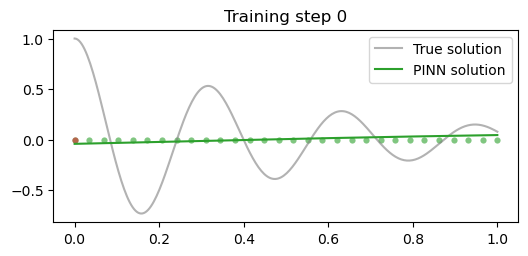

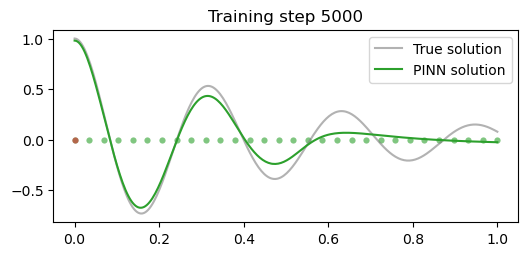

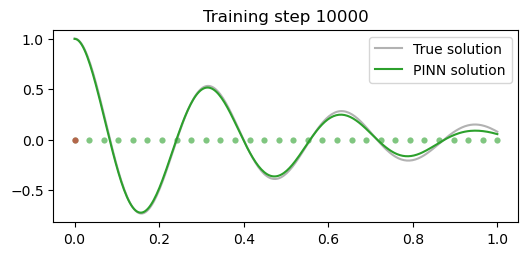

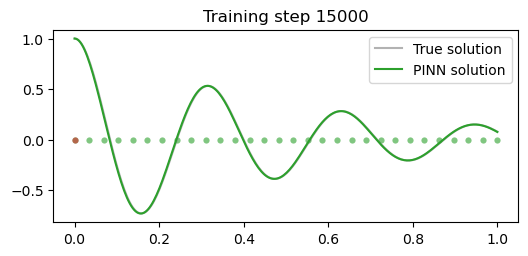

In [4]:
# starting time to test the initial condition of an oscillator
t_init = tf.reshape(tf.constant(0.), shape=(-1, 1))

# define true initial conditions
u_init_pos_true = 1.
u_init_vel_true = 0.

# time points to check physics
t_phys = tf.reshape(tf.linspace(0., 1., 30), shape=(-1, 1))

# instantiate a stochastic gradient descent optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.005)

# hyperparameters for the two PINN loss functions below
lambda1, lambda2 = 1e-1, 1e-4

epochs = 15001
for epoch in range(epochs):
    with tf.GradientTape() as tape:

        # compute initial condition loss
        with tf.GradientTape() as tape_init:
            tape_init.watch(t_init)
            u = osc(t_init)
        dudt = tape_init.gradient(u, t_init)
        loss_pos = (tf.squeeze(u) - u_init_pos_true)**2
        loss_vel = (tf.squeeze(dudt) - u_init_vel_true)**2

        # compute physics loss
        with tf.GradientTape() as tape_phys:
            tape_phys.watch(t_phys)
            with tf.GradientTape() as tape2_phys:
                tape2_phys.watch(t_phys)
                u = osc(t_phys)
            dudt = tape2_phys.gradient(u, t_phys)
        d2udt2 = tape_phys.gradient(dudt, t_phys)
        loss_phys = tf.reduce_mean((d2udt2 + mu*dudt + k*u)**2)

        # combine all losses together
        loss = loss_pos + lambda1*loss_vel + lambda2*loss_phys

    grads = tape.gradient(loss, osc.parameters)
    opt.apply_gradients(zip(grads, osc.parameters))

    # plot results as training progresses
    if epoch % 5000 == 0:
        u = osc(t)
        plt.figure(figsize=(6, 2.5))
        plt.scatter(
            t_phys[:, 0],
            tf.zeros_like(t_phys)[:, 0], s=20, lw=0, color="tab:green", alpha=0.6)
        plt.scatter(t_init[:, 0],
                    tf.zeros_like(t_init)[:, 0], s=20, lw=0, color="tab:red", alpha=0.6)
        plt.plot(t[:, 0], u_true[:, 0], label="True solution", color="tab:grey", alpha=0.6)
        plt.plot(t[:, 0], u[:, 0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {epoch}")
        plt.legend()
        plt.show()